## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import re

import matplotlib.pyplot as plt
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/henryfriesen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_df = pd.read_csv("train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [3]:
mod_df = train_df.dropna(axis=0).copy()

In [4]:
mod_df[mod_df['is_duplicate'] == 0]

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404283,404283,537924,537925,What do you think of the removal of the MagSaf...,What will the CPU upgrade to the 2016 Apple Ma...,0
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [5]:
mod_df[mod_df['is_duplicate'] == 1]

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
...,...,...,...,...,...,...
404280,404280,537922,537923,What are some outfit ideas to wear to a frat p...,What are some outfit ideas wear to a frat them...,1
404281,404281,99131,81495,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...,1
404282,404282,1931,16773,How does a long distance relationship work?,How are long distance relationships maintained?,1
404284,404284,537926,537927,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1


In [ ]:
# Roughly 40% duplicated data

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [6]:
def preprocess(data):
    """
    Function to normalize input text.
    Output normalized texts and stemmed text.
    """
    # lowercase
    data = data.lower()

    # remove unicode characters
    data = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", data)

    # removes stopwords
    stop = stopwords.words('english')
    data = " ".join([word for word in data.split() if word not in (stop)])

    # stem words
    porter = PorterStemmer()
    data = " ".join([porter.stem(word) for word in data.split()])
    
    return data

In [7]:
mod_df['question1'] = mod_df['question1'].apply(preprocess)
mod_df['question2'] = mod_df['question2'].apply(preprocess)
df = mod_df.copy()

In [ ]:
# create some features from the cleaned data.

In [8]:
#contructing the features
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row : len(str(row).split(' ')))
df['q2_n_words'] = df['question2'].apply(lambda row : len(str(row).split(' ')))

def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(w1 & w2)

df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()






,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,1,1,40,34,7,6,5.0,11.0,0.454545,2,0
1,1,3,4,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0,4,1,31,63,4,9,2.0,11.0,0.181818,5,3
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dn,0,1,1,38,30,6,5,3.0,11.0,0.272727,2,0
3,3,7,8,mental lone solv,find remaind math2324math divid 2423,0,1,1,16,36,3,5,0.0,8.0,0.000000,2,0
4,4,9,10,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,3,1,57,28,10,5,2.0,15.0,0.133333,4,2


In [9]:
duplicates = df[df['is_duplicate'] == 1]
non_duplicates = df[df['is_duplicate'] == 0]
tmp_dup = duplicates.sample(2500, random_state=42)
tmp_non_dup = non_duplicates.sample(2500, random_state=42)
sample_df = pd.concat([tmp_dup, tmp_non_dup])
sample_df

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
95846,95846,159763,159764,sell iphon 6s buy iphon se,buy iphon 6s se,1,2,1,26,15,6,4,4.0,9.0,0.444444,3,1
71793,71793,98077,47801,happen famou peopl believ confirm world would ...,happen peopl sold belong 2012 prepar end world,1,2,2,71,46,12,8,5.0,19.0,0.263158,4,0
51542,51542,21553,27734,top pay career option btech mechan engin,best field earn money complet btech mechan engin,1,14,17,40,48,7,8,3.0,15.0,0.200000,31,3
212804,212804,317964,317965,use time product slow day work,bore day work,1,1,1,30,13,6,3,2.0,9.0,0.222222,2,0
373008,373008,503769,503770,revenu model blog,could revenu model blog compani,1,1,1,17,31,3,5,3.0,8.0,0.375000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378571,378571,509975,509976,everi time get sick affect one half face,everi time go even 2 12 hour car trip feel sic...,0,1,1,40,65,8,14,3.0,22.0,0.136364,2,0
183299,183299,52419,280333,solv inequ like x 3x 4,solv inequ f x 2x 3 0,0,3,1,22,21,6,7,3.0,13.0,0.230769,4,2
198044,198044,299149,90593,learn street danc,best way learn danc,0,1,3,17,19,3,4,2.0,7.0,0.285714,4,2
45993,45993,82324,82325,chines websit deliv india,cant petrol deliv onlin india,0,1,1,25,29,4,5,2.0,9.0,0.222222,2,0


In [10]:
# Unused code block. Involved in troubleshooting.

# df['question1'] = df['question1'].apply(lambda x: str(x))
# df['question2'] = df['question2'].apply(lambda x: str(x))

In [11]:
y = sample_df['is_duplicate']
X = sample_df.drop(['id','qid1','qid2', 'is_duplicate'], axis=1)

In [12]:
X

,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
95846,sell iphon 6s buy iphon se,buy iphon 6s se,2,1,26,15,6,4,4.0,9.0,0.444444,3,1
71793,happen famou peopl believ confirm world would ...,happen peopl sold belong 2012 prepar end world,2,2,71,46,12,8,5.0,19.0,0.263158,4,0
51542,top pay career option btech mechan engin,best field earn money complet btech mechan engin,14,17,40,48,7,8,3.0,15.0,0.200000,31,3
212804,use time product slow day work,bore day work,1,1,30,13,6,3,2.0,9.0,0.222222,2,0
373008,revenu model blog,could revenu model blog compani,1,1,17,31,3,5,3.0,8.0,0.375000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
378571,everi time get sick affect one half face,everi time go even 2 12 hour car trip feel sic...,1,1,40,65,8,14,3.0,22.0,0.136364,2,0
183299,solv inequ like x 3x 4,solv inequ f x 2x 3 0,3,1,22,21,6,7,3.0,13.0,0.230769,4,2
198044,learn street danc,best way learn danc,1,3,17,19,3,4,2.0,7.0,0.285714,4,2
45993,chines websit deliv india,cant petrol deliv onlin india,1,1,25,29,4,5,2.0,9.0,0.222222,2,0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [14]:
#training the tf idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

questions = list(X_train['question1']) + list(X_train['question2'])
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

<7000x6388 sparse matrix of type '<class 'numpy.float64'>'
	with 37120 stored elements in Compressed Sparse Row format>

In [15]:
#transforming training data
tfidf_q1= tfidf.transform(X_train['question1']).toarray()
tfidf_q2= tfidf.transform(X_train['question2']).toarray()
X_train= X_train.drop(['question1','question2'],axis=1)
X_train=np.hstack((X_train.values,tfidf_q1,tfidf_q2))
print("shape of our training data ", X_train.shape)

shape of our training data  (3500, 12787)


In [16]:
X_train

array([[ 3.,  3., 32., ...,  0.,  0.,  0.],
       [ 3.,  3., 20., ...,  0.,  0.,  0.],
       [ 1.,  1., 28., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  1., 26., ...,  0.,  0.,  0.],
       [ 2.,  1., 47., ...,  0.,  0.,  0.],
       [ 1.,  4., 22., ...,  0.,  0.,  0.]])

In [17]:

#transforming testing data
tfidf_q1= tfidf.transform(X_test['question1']).toarray()
tfidf_q2= tfidf.transform(X_test['question2']).toarray()
X_test= X_test.drop(['question1','question2'],axis=1)
X_test=np.hstack((X_test.values,tfidf_q1,tfidf_q2))



In [18]:

X_test

array([[ 2.,  2., 18., ...,  0.,  0.,  0.],
       [ 1.,  1., 32., ...,  0.,  0.,  0.],
       [ 2.,  1., 14., ...,  0.,  0.,  0.],
       ...,
       [ 7.,  6., 44., ...,  0.,  0.,  0.],
       [ 4.,  2., 18., ...,  0.,  0.,  0.],
       [ 2.,  2., 30., ...,  0.,  0.,  0.]])

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [19]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"max_depth":[x for x in range(2,10)],
              "n_estimators":[50,100,150,200,300,400,500]}

In [20]:
model = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=30,scoring='neg_log_loss',cv=3,n_jobs=-1)

In [21]:
model.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                            

In [22]:
model.best_params_

{'n_estimators': 50, 'max_depth': 5}

In [23]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=6,n_estimators=50)

In [24]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=25, ...)

In [25]:
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)


In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss

In [27]:
# roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

In [28]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [29]:
# accuracy_score(y_test,predicted_y)

Train log loss =  0.2962036735766035  Test log loss =  0.4187401696202966


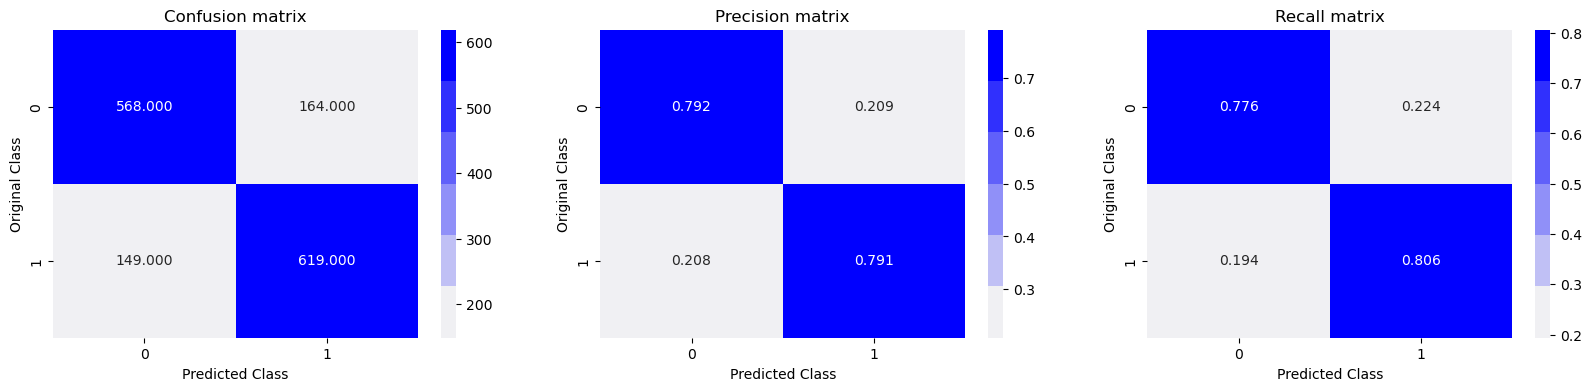

In [30]:
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

In [31]:
# the model worked way too well, which means there is something wrong with the code set-up.
# Investigation required.

# Fixed. target used in X training data.
# Come back to and retrain whole model again.